In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import Src.YamlUtils as yu
import Src.DicData as dade
import Src.Slideshow as slide
import Src.OversampleStreamData as osa

In [3]:
import os

img_path = "Z:/ForschB/comma_ai_extracted/{}/imgs"
train_path = "Z:/ForschB/comma_ai_extracted"
comma_ai_train_yaml = "Z:/ForschB/comma_ai_extracted/{}/training.yaml"

dirs = os.listdir(train_path)

yamls = []

yamls.append(comma_ai_train_yaml.format(dirs[0]))

In [4]:
dicts = []
dicts.append(yu.read_yaml(yamls[0]))

In [5]:
def do_all(dic):
    dade.remove_data_with_speed_lower_than_threshold(dic)
    max_abs_speed, max_abs_steer = dade.get_max_abs_speed_and_steering(dic)
    
    dade.add_speed_classes_to_dic(dic, threshold=0.05)
    
    dade.normalize_dic_steering(dic, max_abs_steer)
    # dade.normalize_dic_speed(dic, max_abs_speed)
    
    dade.add_steer_classes_to_dic(dic)
    dade.add_speed_cost_weight_to_dic(dic)
    dade.add_steer_cost_weight_to_dic(dic)
    
    return max_abs_steer, max_abs_speed

In [6]:
max_steers = []
max_speeds = []

max_steer, max_speed = do_all(dicts[0])
max_steers.append(max_steer)
max_speeds.append(max_speed)

In [7]:
oversample_dict00_ho = yu.read_yaml("Z:/ForschB/comma_ai_oversampled/stream_oversample_comma.ai_dict00_ho/training.yaml")

In [8]:
dade.remove_data_with_speed_lower_than_threshold(oversample_dict00_ho)
dade.add_speed_classes_to_dic(oversample_dict00_ho, threshold=0.05)

dade.normalize_dic_steering(oversample_dict00_ho, max_steers[0])

dade.add_speed_cost_weight_to_dic(oversample_dict00_ho)


# after
max_abs_speed, max_abs_steer = dade.get_max_abs_speed_and_steering(oversample_dict00_ho)
dade.normalize_dic_steering(oversample_dict00_ho, max_abs_steer - 0.05)

dade.add_steer_classes_to_dic(oversample_dict00_ho)
dade.add_steer_cost_weight_to_dic(oversample_dict00_ho)

distribution in dict 

0: 8806
1: 11275
2: 7419
3: 10346
4: 10481
5: 8253
6: 13235
7: 10876
8: 12661
9: 11359
10: 11451
11: 6639
12: 11526


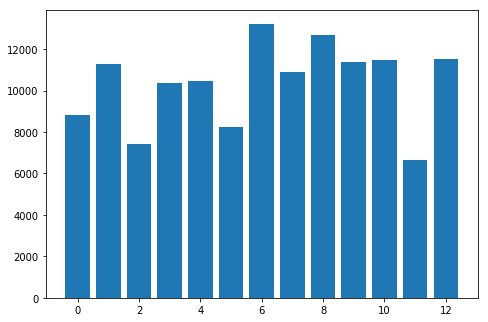

In [9]:
_ = osa.analyze_steer_in_dic(oversample_dict00_ho)

In [ ]:
import copy

def copy_dic_till_key(dic, key):
    result = {}
    
    for k in dic:
        result[k] = copy.deepcopy(dic[k])
        
        if k == key:
            break
    
    return result

def copy_dic_from_till_keys(dic, f, t):
    result = {}
    
    do_copy = False
    
    for k in dic:
        
        if k == f:
            do_copy = True
        
        if do_copy:
            result[k] = copy.deepcopy(dic[k])
        
        if k == t:
            break
    
    return result

In [ ]:
dict00_ho = copy_dic_from_till_keys(dicts[0], 4240, 33300)

In [ ]:
max_abs_speed, max_abs_steer = dade.get_max_abs_speed_and_steering(dict00_ho)
dade.normalize_dic_steering(dict00_ho, max_abs_steer - 0.05)

dade.add_steer_classes_to_dic(dict00_ho)
dade.add_steer_cost_weight_to_dic(dict00_ho)

distribution in dict 

0: 281
1: 55
2: 258
3: 701
4: 1409
5: 4291
6: 13235
7: 5607
8: 1678
9: 754
10: 384
11: 222
12: 186


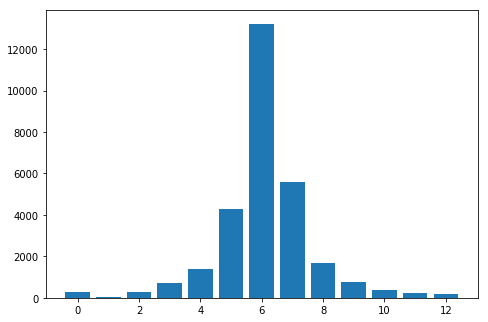

distribution after oversampling 

0: 13207
1: 13200
2: 13158
3: 12618
4: 12681
5: 12873
6: 13235
7: 11214
8: 11746
9: 12818
10: 13056
11: 13098
12: 13206


In [16]:
sorted_keys = osa.analyze_steer_in_dic(dict00_ho)
simple_over_dict00_ho_sorted = osa.oversample_steer_in_dic_sorted(dict00_ho, sorted_keys)

In [17]:
slide.slideshow(simple_over_dict00_ho_sorted,
                img_path.format(dirs[0]), 
                minimal_steer=-1.0, maximal_steer=1.0,
                minimal_speed=0.0, maximal_speed=max_speeds[0],
                hz=100, img_file_type="png",
                verbose=1)

In [19]:
import Src.KerasSequence as ks
import Src.ImgProcessing as img_proc

Using TensorFlow backend.


In [33]:
img_processor = img_proc.ImgProcessor()

img_processor.crop = False
img_processor.augment = False

img_processor.fx = 0.2
img_processor.fy = 0.4

In [34]:
batch_size = 1
sequence_size = 32

In [53]:
oversample_steer_gen_00_ho = ks.SequenceGeneratorSteer(
    oversample_dict00_ho, "Z:/ForschB/comma_ai_oversampled/stream_oversample_comma.ai_dict00_ho/imgs", 
    img_processor, batch_size=batch_size, sequence_size=sequence_size, img_file_type="png"
)

oversample_steer_gen_00_ho.return_weights = False


oversample_steer_gen_00_ho = ks.SequenceGeneratorSteer(
    oversample_dict00_ho, "Z:/ForschB/comma_ai_oversampled/stream_oversample_comma.ai_dict00_ho/imgs", 
    img_processor, batch_size=1, sequence_size=128, img_file_type="png"
)

oversample_steer_gen_00_ho.return_weights = False


simple_over_gen = ks.GeneratorSteer(
    simple_over_dict00_ho_sorted, img_path.format(dirs[0]), 
    img_processor, batch_size=512, img_file_type="png"
)

simple_over_gen.return_weights = False

In [38]:
(imgs, _, ) = oversample_steer_gen_00_ho[0]
img_shape = imgs[0][0][0].shape
print(img_shape)

(64, 64, 3)


In [26]:
import Src.Models as models
import Src.KerasCallbacks as kc

In [55]:
models.reset_session()

In [56]:
model = models.fabian_ket_cnn_research_b_steer_paper(img_shape, batch_size, # stateful=True, 
                                                     compile_model=True, optimizer="adam", 
                                                     bias=True)

reset_states_callback = kc.KerasRestStatesCallback(model)

Parameter model ref: 0x1de65754518
Callback  model ref: 0x1de65754518


In [57]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       (None, 64, 64, 3)         0         
_________________________________________________________________
conv01 (Conv2D)              (None, 64, 64, 96)        34944     
_________________________________________________________________
pool01 (MaxPooling2D)        (None, 32, 32, 96)        0         
_________________________________________________________________
conv_batch_norm01 (BatchNorm (None, 32, 32, 96)        384       
_________________________________________________________________
conv_relu01 (Activation)     (None, 32, 32, 96)        0         
_________________________________________________________________
conv02 (Conv2D)              (None, 32, 32, 256)       614656    
_________________________________________________________________
pool02 (MaxPooling2D)        (None, 16, 16, 256)       0         
__________

In [37]:
model_save_file = "steer_model_weights_64x64_comma.ai_lstm_research_b_steer_paper()_adam_bias_ho.h5"

In [23]:
model.load_weights( model_save_file )

In [59]:
history = model.fit_generator(
    generator=simple_over_gen,
    steps_per_epoch=len(simple_over_gen),
    # validation_data=steer_gen_04_ho,
    # validation_steps=len(steer_gen_04_ho),
    epochs=5,
    verbose=1,
    workers=1,
    use_multiprocessing=False,
    callbacks=[reset_states_callback],
    shuffle=False)

Epoch 1/5
325/325 [==============================] - 219s 673ms/step - loss: 0.5645 - mean_absolute_error: 0.5645
Epoch 2/5
325/325 [==============================] - 216s 664ms/step - loss: 0.5645 - mean_absolute_error: 0.5645
Epoch 3/5
325/325 [==============================] - 224s 689ms/step - loss: 0.5641 - mean_absolute_error: 0.5641
Epoch 4/5
325/325 [==============================] - 218s 671ms/step - loss: 0.5634 - mean_absolute_error: 0.5634
Epoch 5/5
325/325 [==============================] - 214s 657ms/step - loss: 0.5635 - mean_absolute_error: 0.5635


In [39]:
model.save_weights( model_save_file ) # 0.0624

In [31]:
model.reset_states()

In [43]:
slide.slideshow(dict00_ho,
                #oversample_dict00_ho, 
                img_path.format(dirs[0]), 
                #"Z:/ForschB/comma_ai_oversampled/stream_oversample_comma.ai_dict00_ho/imgs",
                minimal_steer=-1.0, maximal_steer=1.0,
                minimal_speed=0.0, maximal_speed=max_speeds[0],
                hz=100, img_file_type="png",
                steer_model=model,
                img_processor=img_processor,
                sequential=True,
                verbose=1)

steer_model prediction: 0.6167027950286865
steer_model prediction: 0.6791611909866333
steer_model prediction: 0.6906676292419434
steer_model prediction: 0.6943997144699097
steer_model prediction: 0.6966186761856079
steer_model prediction: 0.6982245445251465
steer_model prediction: 0.6994079351425171
steer_model prediction: 0.7002672553062439
steer_model prediction: 0.7008816003799438
steer_model prediction: 0.701315701007843
steer_model prediction: 0.7016196250915527
steer_model prediction: 0.7018311023712158
steer_model prediction: 0.7019777297973633
steer_model prediction: 0.7020790576934814
steer_model prediction: 0.7021487951278687
steer_model prediction: 0.7021969556808472
steer_model prediction: 0.7022299766540527
steer_model prediction: 0.7022527456283569
steer_model prediction: 0.7022683620452881
steer_model prediction: 0.7022790908813477
steer_model prediction: 0.7022864818572998
steer_model prediction: 0.7022915482521057
steer_model prediction: 0.7022950053215027
steer_model 

steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model

steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model

steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model

steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model prediction: 0.7023026347160339
steer_model

In [124]:
test_img_zeros = np.zeros((1,1,64,64,3))
test_pre_zeros = np.zeros((1,1,1))

test_img_ones = np.ones((1,1,64,64,3))
test_pre_ones = np.ones((1,1,1))

model.predict([test_img_zeros, test_pre_zeros], batch_size=1)

array([[[0.5753548]]], dtype=float32)

In [59]:
[imgs, pre], steers = oversample_steer_gen_00_ho[0]